
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sbn

In [87]:
# Dropout: 0 e 10%
DROPOUT = 0.10
#Learning rates: 2.5e-5 e 5e-5
LEARNING_RATE = 5e-5
TRAIN_NUM = '04'

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModel.from_pretrained("xlm-roberta-large")

In [5]:
df = pd.read_csv('../datasets/b2w_preprocessed.csv')

In [6]:
df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [7]:
df.shape

(71516, 2)

In [8]:
reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [9]:
print(reviews_batch_01.shape)
print(labels_batch_01.shape)
print(reviews_batch_02.shape)
print(labels_batch_02.shape)

(35758,)
(35758,)
(35758,)
(35758,)


In [10]:
labels_batch_01.value_counts()

rating
1    17914
0    17844
Name: count, dtype: int64

In [11]:
#reviews = ["This movie was great!", "I didn't like this movie.", "Ate que gostei", "Nao achei tao legal"]
#labels = [1, 0, 1, 0]
reviews = reviews_batch_01
labels = labels_batch_01

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns minnutos para ser concluído

In [12]:
embeddings = []
for review in tqdm((reviews),desc='Processing'):
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing: 100%|██████████| 35758/35758 [3:03:34<00:00,  3.25it/s]  


In [88]:
embeddings_array = np.vstack(embeddings)

In [89]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

35758 embeddings de 1024 dimensões


#### Feature based 2

In [90]:
additional_features_1 = np.array([[len(str(review_batch_1).split())] for review_batch_1 in reviews_batch_01])
additional_features_2 = np.array([[len(str(review_batch_2).split())] for review_batch_2 in reviews_batch_02])

In [91]:
print(embeddings_array.shape)
print(additional_features_1.shape)
print(additional_features_2.shape)

(35758, 1024)
(35758, 1)
(35758, 1)


#### Combinando embeddings_array e additional_features

In [92]:
#combined_features = np.hstack((embeddings_array, additional_features))
combined_features = np.hstack((embeddings_array, additional_features_1, additional_features_2))

#### Dividindo dataset treino e teste

In [93]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [94]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

In [95]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

#### Arquitetura rede neural MLP

In [96]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                24648     
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 24,673
Trainable params: 24,673
Non-trainable params: 0
_________________________________________________________________


In [98]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Cross-validation

In [99]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

#### Treinamento do modelo

In [100]:
fold = 0

fold_train_losses = []
fold_train_accs = []
fold_train_f1_scs = []

fold_losses = []
fold_accuracies = []
fold_f1_scores = []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

val_tprs = []
val_aucs = []
val_mean_fpr = np.linspace(0, 1, 100)

for train_indices, val_indices in tqdm(kf.split(combined_features),desc='Processing'):
    fold+=1
    print(f'fold = {fold}')
    
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=0,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=[EarlyStopping('loss', patience=3)],
    )
    
    # fold train loss
    fold_train_losses.append(model_history.history['loss'])
    
    # fold train acc
    fold_train_accs.append(model_history.history['accuracy'])
    
    # fold train y pred
    y_pred_train = (model.predict(X_train_fold_tensor) > 0.5).astype(int)
    
    # fold train f1 sc
    train_f1_score = f1_score(y_train_fold_tensor, y_pred_train)
    fold_train_f1_scs.append(train_f1_score)
    
    # train roc curve and auc
    fpr, tpr, thresholds = roc_curve(y_train_fold_tensor, y_pred_train)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)
    
    # -----------------------------------------------------------------------
    
    # val pred
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    # val loss
    fold_loss = log_loss(y_val_fold, y_pred_val_binary)
    fold_losses.append(fold_loss)
    
    # val acc
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    # val f1 sc
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)

print('Treino finalizado')

Processing: 0it [00:00, ?it/s]

fold = 1
112/112 [==============================] - 0s 770us/step


Processing: 1it [00:14, 14.59s/it]

fold = 2
112/112 [==============================] - 0s 777us/step


Processing: 2it [00:28, 14.20s/it]

fold = 3
112/112 [==============================] - 0s 765us/step


Processing: 3it [00:42, 14.02s/it]

fold = 4
112/112 [==============================] - 0s 986us/step


Processing: 4it [00:56, 13.94s/it]

fold = 5
112/112 [==============================] - 0s 779us/step


Processing: 5it [01:10, 13.97s/it]

fold = 6
112/112 [==============================] - 0s 830us/step


Processing: 6it [01:24, 13.92s/it]

fold = 7
112/112 [==============================] - 0s 791us/step


Processing: 7it [01:37, 13.90s/it]

fold = 8
112/112 [==============================] - 0s 849us/step


Processing: 8it [01:51, 13.91s/it]

fold = 9
112/112 [==============================] - 0s 741us/step


Processing: 9it [02:05, 13.84s/it]

fold = 10
112/112 [==============================] - 0s 730us/step


Processing: 10it [02:14, 13.44s/it]

Treino finalizado


In [101]:
# train loss
mean_fold_train_loss = round(np.mean([np.mean(train_loss) for train_loss in fold_train_losses]),4)
print(f"mean train loss: {np.mean(mean_fold_train_loss)}")

# train acc
mean_fold_train_acc = round(np.mean([np.mean(train_acc) for train_acc in fold_train_accs]),4)
print(f"mean train accuracies: {np.mean(mean_fold_train_acc)}")

# train f1 score
print(f"mean train f1 score: {np.mean(fold_train_f1_scs)}")

print('-'*80)

# val loss
print(f"mean val loss: {round(np.mean(fold_losses),4)}")

# val acc
print(f"mean val accuracies: {np.mean(fold_accuracies)}")

# val f1 score
print(f"mean val f1 score: {np.mean(fold_f1_scores)}")

mean train loss: 0.1697
mean train accuracies: 0.9377
mean train f1 score: 0.9462025813305731
--------------------------------------------------------------------------------
mean val loss: 0.8596
mean val accuracies: 0.9460823594749769
mean val f1 score: 0.9455941094215566


In [102]:
graphs_path = f'b2w_09_tlm_gran_fb2_mlp_train_{TRAIN_NUM}'

In [103]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'./graphs/{graphs_path}/b2w_tlm_gran_fb2_mlp_{metric}_train_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_train_folds(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'./graphs/{graphs_path}/tlm_gran_fb2_mlp_{metric}_train_loss_folds_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_roc_auc_curve(desc, mean_tpr, mean_auc):
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'./graphs/{graphs_path}/tlm_gran_fb2_mlp_{desc}_train_roc_auc_curve_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_confunsion_matrix(cm):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title("Matriz de Confusão", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predito')
    plt.savefig(f'./graphs/{graphs_path}/tlm_gran_fb2_mlp_val_confusion_matrix_test_{TRAIN_NUM}.png')
    plt.show()

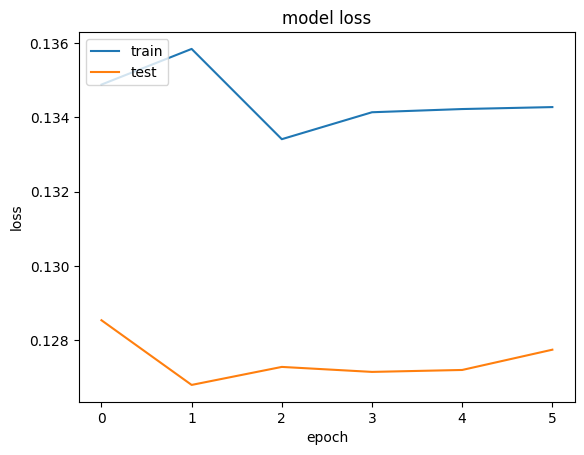

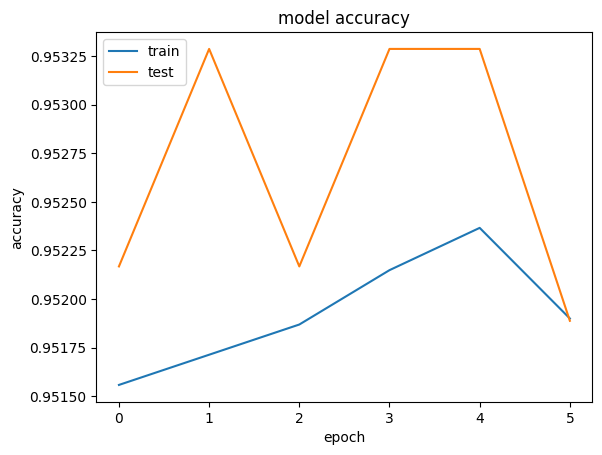

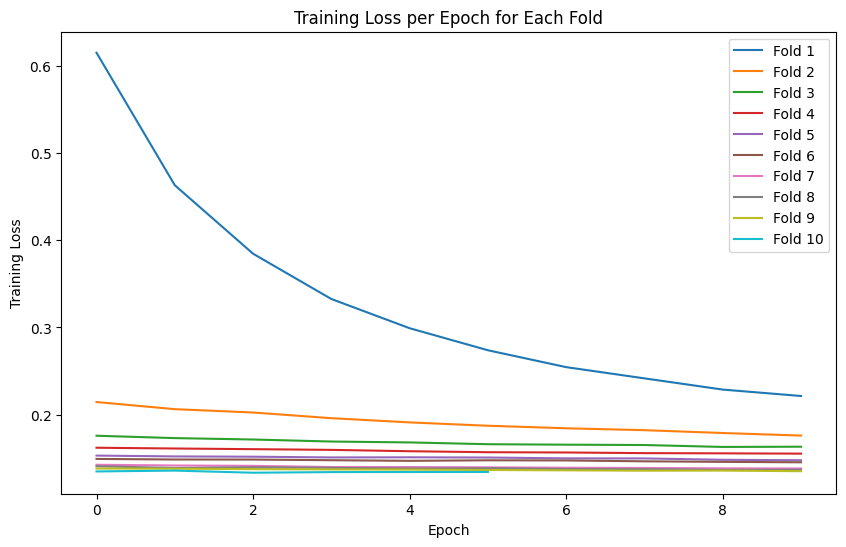

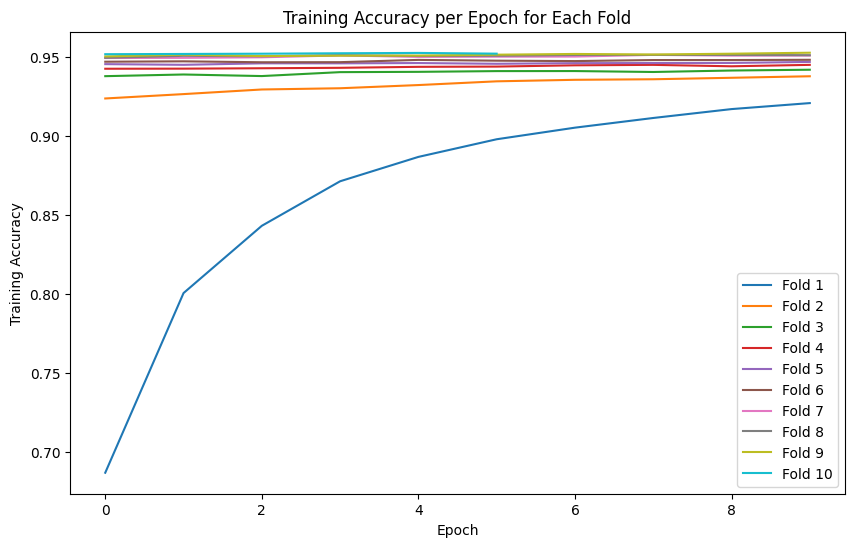

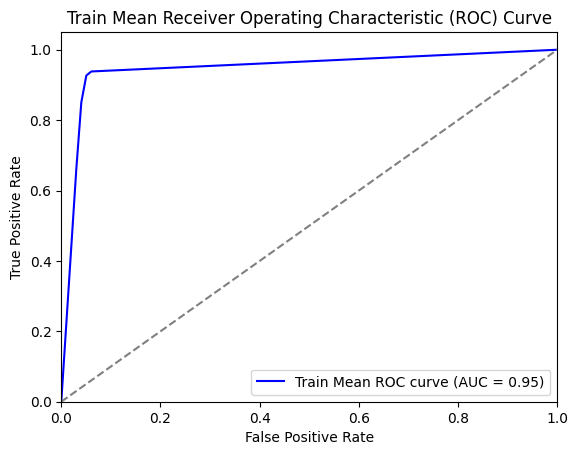

In [104]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')

plot_train_folds(fold_train_losses, 'Loss')
plot_train_folds(fold_train_accs, 'Accuracy')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plot_roc_auc_curve('Train', mean_tpr, mean_auc)

In [105]:
predict = np.round(model.predict(X_val_fold_tensor))

112/112 [==============================] - 0s 807us/step


In [106]:
accuracy = accuracy_score(y_val_fold_tensor, predict)
accuracy

0.9518881118881118

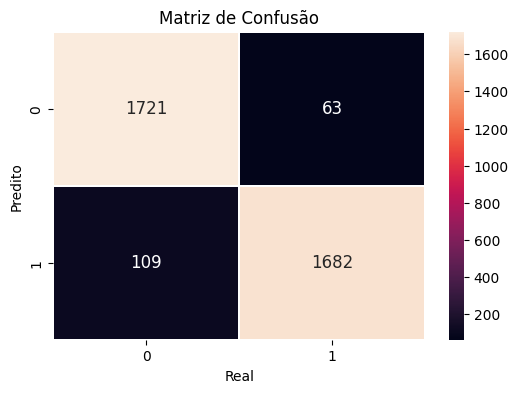

In [107]:
cm = confusion_matrix(y_val_fold_tensor, predict)
plot_confunsion_matrix(cm)